In [2]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

from drdmannturb.common import *
from drdmannturb.calibration import CalibrationProblem
from drdmannturb import OnePointSpectraDataGenerator

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

In [3]:
import fracturbulence as ft

In [4]:
spectra = np.genfromtxt("../script/Spectra.dat", delimiter=',')


In [5]:
####################################
### Configuration
####################################

config = {
    'type_EddyLifetime' :   'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'hidden_layer_size' :   10,
    'learn_nu'          :   True, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1,  #originally: 1.e-1,
    'regularization'    :   1.e-2,
    'nepochs'           :   2,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'       :   '../script/Spectra.dat',
    'Uref'              :   10, # m/s
    'zref'              :   1, #m
    'domain'            :   torch.logspace(-2, 2, 20), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   7.e-2, # 0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   savedir,
    'input_folder'      :   '../script/'
}
pb = CalibrationProblem(**config)

['relu', 'relu']


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
####################################
#Calculating turbulence parameters according to IEC standards
# we assume a hub height z=150m corresponding to the IEA 15MW wind turbine hub height
zref=config['zref']; # Hub height in meters
Uref=config['Uref']; # Average Hub height velocity in m/s
Iref = 0.14
sigma1=Iref*(0.75*Uref+5.6)
Lambda1=42; # Longitudinal turbulence scale parameter at hub height


#Mann model parameters
#Gamma = 3.9
#sigma = 0.55*sigma1
#L=0.8*Lambda1;


z0=0.01
ustar=0.41*Uref/log(zref/z0)

L     = 14.09
Gamma = 3.9
sigma = 0.15174254

print(L,Gamma,sigma)

parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)


if(config['data_type']=='Custom'):
    if config['spectra_file'] is not None:
        spectra_file=config['spectra_file']
        print('Reading file' + spectra_file + '\n')
        CustomData=torch.tensor(np.genfromtxt(spectra_file,skip_header=1,delimiter=','))
        f=CustomData[:,0]
        k1_data_pts=2*torch.pi*f/Uref

DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

### Data perturbation
data_noise_magnitude = config['noisy_data']
if data_noise_magnitude:
    Data[1][:] *= np.exp(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape))

DataValues = Data[1]

14.09 3.9 0.15174254
Reading file../script/Spectra.dat

Reading file ../script/Spectra.dat

DataValues is on -1


In [7]:
type(k1_data_pts)

torch.Tensor

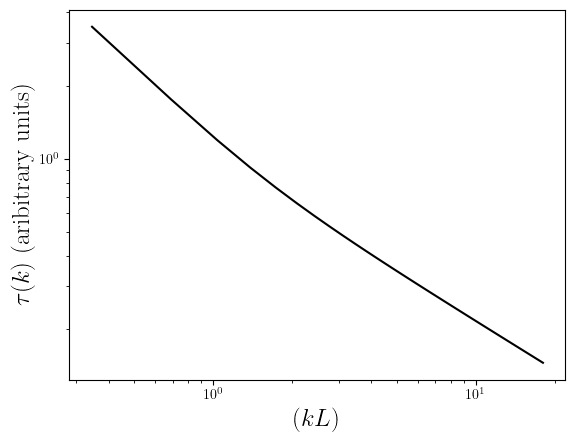

In [8]:
IECtau=MannEddyLifetime(k1_data_pts*L)
plt.figure(1)
plt.loglog(k1_data_pts*L,IECtau,'k')
#plt.xlim(0.1,60)
plt.ylabel(r'$\tau(k)$ (aribitrary units)',fontsize=18)
plt.xlabel(r'$(kL)$',fontsize=18)
plt.show()
#plt.savefig('tau.png')

[format_output] -- HERE!


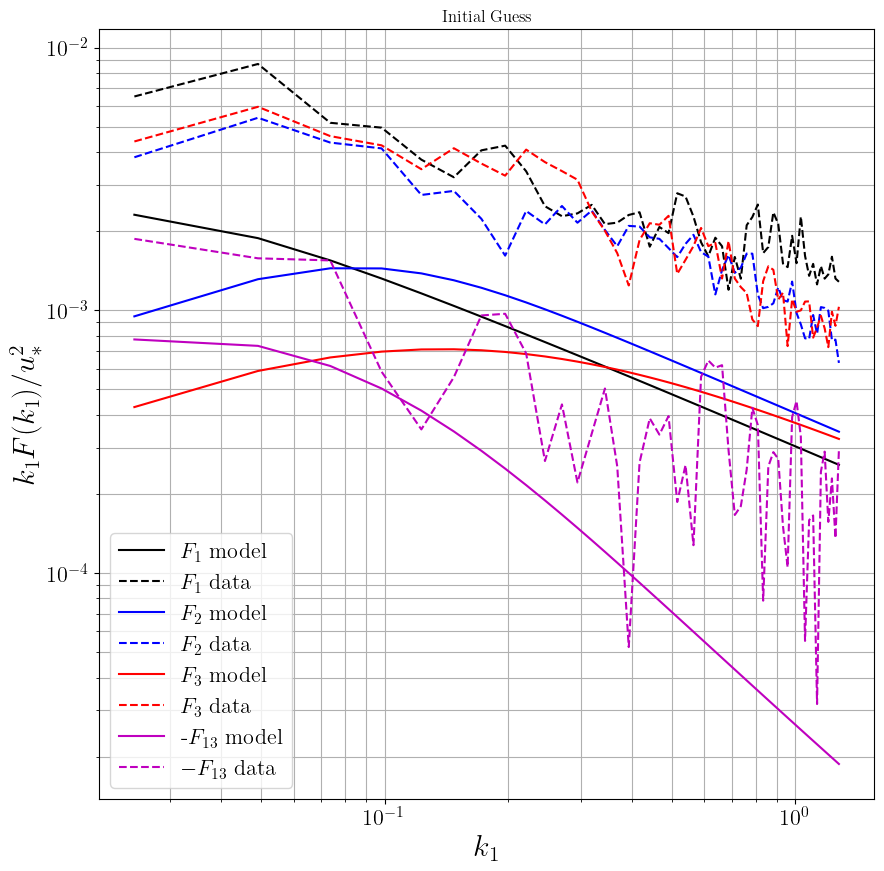

In [9]:
plt.rc('text',usetex=True)
plt.rc('font',family='serif')


kF = pb.eval(k1_data_pts)
plt.figure(1,figsize=(10,10))
clr=['black','blue','red']
plt.figure(1)
for i in range(3):
    plt.plot(k1_data_pts, kF[i], '-', color=clr[i], label=r'$F_{0:d}$ model'.format(i+1))
    plt.plot(k1_data_pts, DataValues[:,i,i], '--',color=clr[i],label=r'$F_{0:d}$ data'.format(i+1) )#, label=r'$F_{0:d}$ data'.format(i+1))
plt.plot(k1_data_pts, -kF[3], '-m', label=r'-$F_{13}$ model')
plt.plot(k1_data_pts, -DataValues[:,0,2], '--m', label=r'$-F_{13}$ data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_1$',fontsize=22)
#plt.xlim(0.01,2)
#plt.ylim(0.00001,0.1)
plt.ylabel(r'$k_1 F(k_1)/u_\ast^2$',fontsize=22)
plt.legend(loc='lower left',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(which='both')
plt.title("Initial Guess")
plt.show()

In [10]:
opt_params = pb.calibrate(Data=Data, **config)


Calibrating MannNet...
torch.Size([208])
Initial loss:  1.9867570608188125

[Calibration.py -- calibrate]-> Epoch 0

loss  =  1.9875549695620698
loss  =  0.29499254751197046
loss  =  0.2910604241607953
loss  =  0.2890433459062797
loss  =  0.2833156890396438
loss  =  0.27852093402479
loss  =  0.2779529644328837
loss  =  0.2770433334067088
loss  =  0.2752093155043039
loss  =  0.26920780580558784
loss  =  0.25818898520921113
loss  =  0.2554215170528683
loss  =  0.2544665423175568
loss  =  0.2532020715868075
loss  =  0.24838926108470846
loss  =  0.24214653494169963
loss  =  0.2392250581002325
loss  =  0.30339981222412427
loss  =  0.21794757606257606
loss  =  0.2527742815130592
loss  =  0.2275255154055258
loss  =  0.21543750000044237
loss  =  0.2135059861071938
loss  =  0.21121243407739504
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1



/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss  =  0.21121243407739504
loss  =  0.2115989497961953
loss  =  0.2052343531697618
loss  =  0.21820313974088015
loss  =  0.20515719802487545
loss  =  0.20459107954692046
loss  =  0.4438517861271789
loss  =  0.21036151324812907
loss  =  0.20426655550123676
loss  =  0.20419845651404073
loss  =  0.20410180234946684
loss  =  0.20397476731096134
loss  =  0.20384920608423945
loss  =  0.20381708583385666
loss  =  0.2037508922881506
loss  =  0.203671180231805
loss  =  0.20356484918217
loss  =  0.2035355900019649
loss  =  0.2034988162510312
loss  =  0.20341981060556172
loss  =  0.20326253983346776
loss  =  0.20301872757224054
loss  =  0.20247872254373686
loss  =  0.20268572103261076
loss  =  0.20208653498728546
---------------------------------



{Calibration.py -- calibrate} Calibration terminated.

loss = 0.20208653498728546
tol  = 0.001
k1.size: torch.Size([52])   self.kF_data_vals: torch.Size([208])


In [11]:
X = [1, 2, 3, 4]

In [12]:
plt.plot(X)

In [13]:
plt.savefig(savedir)